### Notebook exploring how to create patches in PyTorch
#### Focused on an example image

In [2]:
import matplotlib.pyplot as plt
from openslide import open_slide
import numpy as np
from PIL import Image
import os
import torch
from torchvision import io, transforms
from torchvision.utils import Image, ImageDraw
from torchvision.transforms.functional import to_pil_image

Image.MAX_IMAGE_PIXELS = None

In [36]:
# Read in example WSI
SVS_DIR='/Users/alexandrasmith/Desktop/Workspace/Projects/masters/data/raw/svs_files/'
svs_files = os.listdir(SVS_DIR)
svs_file = SVS_DIR + svs_files[1]
slide = open_slide(svs_file)
FILE_NAME=svs_file.replace('.svs', '').replace(SVS_DIR, '')

In [7]:
# Get 10X thumbnail of slide to work with
slide_props = slide.properties
slide_width = int(slide_props['openslide.level[1].width']); slide_height = int(slide_props['openslide.level[1].height'])
slide10X = np.array(slide.get_thumbnail(size=(slide_width, slide_height)))

In [8]:
# Read in example labelled image
MASK_DIR='/Users/alexandrasmith/Desktop/Workspace/Projects/masters/data/interim/masks/'
mask_file = MASK_DIR + FILE_NAME + '.png'
mask = np.array(Image.open(mask_file))
# reshape mask file to be same size as SVS
mask = mask[:slide10X.shape[0], :slide10X.shape[1]]

In [9]:
# Check they are the same shapes
print(slide_width, slide_height)
print(slide10X.shape)
print(len(mask.shape))
print(mask.shape) # height, width ?

17954 20401
(20401, 17954, 3)
2
(20401, 17954)


Text(0.5, 1.0, 'Segmentation mask')

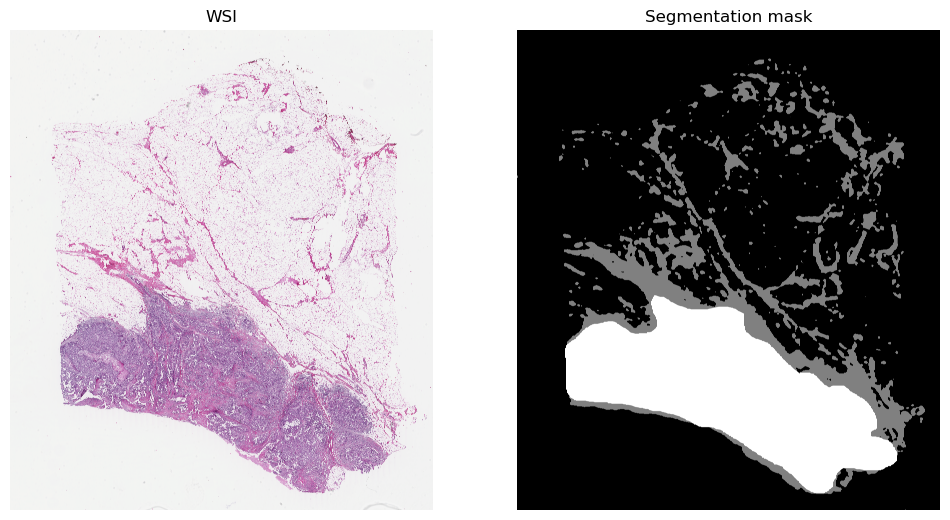

In [37]:
# Visually confirm that we are working with corresponding images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.imshow(slide10X); ax1.axis('off'); ax1.set_title("WSI")
ax2.imshow(mask, cmap="gray"); ax2.axis('off'); ax2.set_title("Segmentation mask")

## Testing my functions

In [10]:
import sys
sys.path.append('/Users/alexandrasmith/Desktop/Workspace/Projects/masters/src/')
from data.preprocessing import *

In [11]:
PATCH_SIZE=5000
STRIDE=PATCH_SIZE

In [19]:
print(slide10X.shape)

(23395, 33557, 3)


In [12]:
im_patches = image_to_patches(slide10X, PATCH_SIZE, STRIDE)

In [13]:
print(im_patches.shape)

torch.Size([12, 3, 5000, 5000])


In [69]:
first_patch = im_patches[0, :, :, :]
print(first_patch.shape)

i = 6
ith_patch = im_patches[i, :, :, :]

torch.Size([3, 5000, 5000])


In [70]:
p1 = first_patch.numpy()
p2 = ith_patch.numpy()

In [71]:
print(np.average(p1)*255)
print(np.average(p2)*255)

241.96978479623795
217.16305911540985


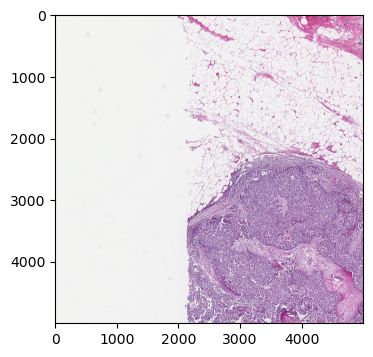

In [72]:
# View patch
plt.figure(figsize=(4, 4))
plt.imshow(np.transpose(ith_patch.numpy(), (1, 2, 0)))

In [8]:
mask_patches = image_to_patches(mask, PATCH_SIZE, STRIDE)

print(mask_patches.shape)

torch.Size([24, 5000, 5000])


In [8]:
first_m_patch = mask_patches[0, :, :]
print(first_m_patch.shape)

i = 3
ith_m_patch = mask_patches[i, :, :]

torch.Size([5000, 5000])


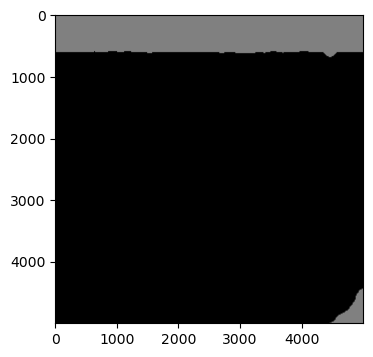

In [29]:
# View patch
plt.figure(figsize=(4, 4))
plt.imshow(first_m_patch.numpy(), cmap="gray", vmin=0, vmax=1)

In [11]:
# Troubleshooting the function for binary images
unique_values, unique_indices = torch.unique(first_m_patch, return_inverse=True)
print("Unique values:", unique_values)
print("Number of unique values:", len(unique_values))

Unique values: tensor([0.0000, 0.5000])
Number of unique values: 2


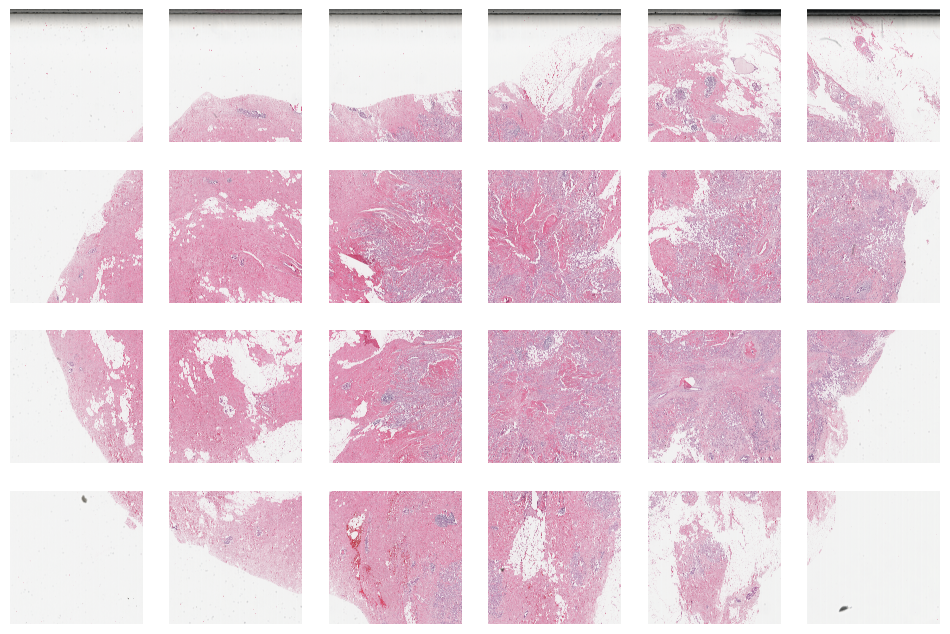

In [27]:
fig, axes = plt.subplots(4, 6, figsize=(12, 8))
axs = axes.ravel()
for i, ax in enumerate(axs):
    ax.imshow(np.transpose(im_patches[i, :, :, :].numpy(), (1, 2, 0)))
    ax.axis('off')

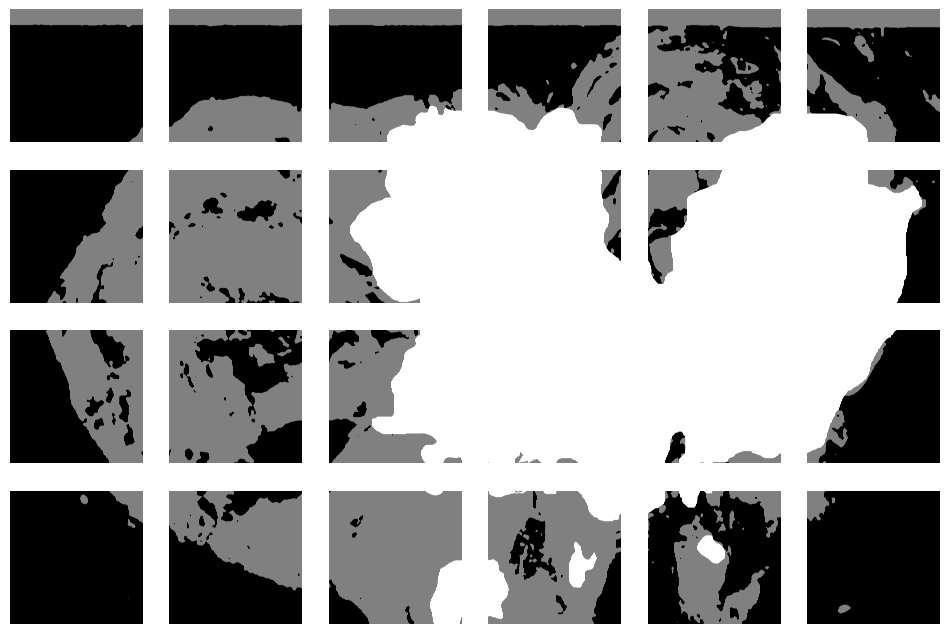

In [9]:
fig, axes = plt.subplots(4, 6, figsize=(12, 8))
axs = axes.ravel()
for i, ax in enumerate(axs):
    ax.imshow(mask_patches[i, :, :].numpy(), cmap="gray", vmin=0, vmax=1)
    ax.axis('off')

In [9]:
# Testing 'discard' function
tissue_patches, seg_patches = discard_background_patches(im_patches, mask_patches, PATCH_SIZE)

In [10]:
print(tissue_patches.shape)
print(seg_patches.shape) # should have same number of patches

torch.Size([21, 3, 5000, 5000])
torch.Size([21, 5000, 5000])


IndexError: index 21 is out of bounds for dimension 0 with size 21

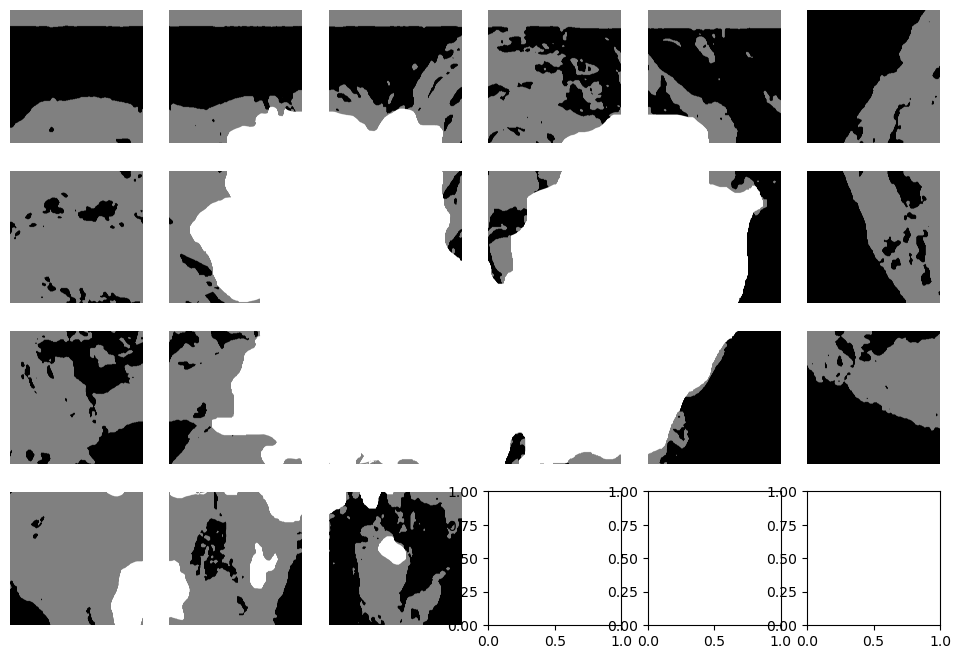

In [11]:
# Visualise the patches that were kept
fig, axes = plt.subplots(4, 6, figsize=(12, 8))
axs = axes.ravel()
for i, ax in enumerate(axs):
    ax.imshow(seg_patches[i, :, :].numpy(), cmap="gray", vmin=0, vmax=1)
    ax.axis('off')

In [3]:
# Test load_data() function

PATCH_SIZE=5000
STRIDE=PATCH_SIZE
SVS_DIR='/Users/alexandrasmith/Desktop/Workspace/Projects/masters/data/raw/svs_files/'
MASK_DIR='/Users/alexandrasmith/Desktop/Workspace/Projects/masters/data/interim/masks/'
NUM_CLASSES=2


In [4]:
patches, labels = load_data(SVS_DIR, MASK_DIR, PATCH_SIZE, STRIDE, NUM_CLASSES)

TCGA-A2-A0SY-01Z-00-DX1.279A5479-E183-4F79-AF40-50BF1834BA4A
Finished discarding background patches for file TCGA-A2-A0SY-01Z-00-DX1.279A5479-E183-4F79-AF40-50BF1834BA4A
Concatenated patches from file TCGA-A2-A0SY-01Z-00-DX1.279A5479-E183-4F79-AF40-50BF1834BA4A to list of all patches
TCGA-A2-A0CX-01Z-00-DX1.F07C75AB-E568-45CB-B497-37C712490393
Finished discarding background patches for file TCGA-A2-A0CX-01Z-00-DX1.F07C75AB-E568-45CB-B497-37C712490393
Concatenated patches from file TCGA-A2-A0CX-01Z-00-DX1.F07C75AB-E568-45CB-B497-37C712490393 to list of all patches
TCGA-C8-A12Q-01Z-00-DX1.CE74E5B7-FD30-4CBE-8716-ECCF2213AAC3
Finished discarding background patches for file TCGA-C8-A12Q-01Z-00-DX1.CE74E5B7-FD30-4CBE-8716-ECCF2213AAC3
Concatenated patches from file TCGA-C8-A12Q-01Z-00-DX1.CE74E5B7-FD30-4CBE-8716-ECCF2213AAC3 to list of all patches
TCGA-A2-A0SW-01Z-00-DX1.E1EA0407-B831-4D75-826E-80B82B821797
Finished discarding background patches for file TCGA-A2-A0SW-01Z-00-DX1.E1EA0407-B83

In [6]:
print(patches.shape)
print(len(labels))

torch.Size([86, 3, 5000, 5000])
86


In [12]:
print(type(labels))

<class 'torch.Tensor'>


In [11]:
print(labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])


In [10]:
labels = torch.tensor(labels, dtype=torch.long)
print(labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])


/var/folders/lj/23hp30kd6vg4nl2my4pt2dn80000gn/T/ipykernel_54070/366308947.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
